In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:19, 2520.01it/s]



Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Анализ текстов

**1. Посчитайте количество отзывов в разных городах и на разные банки**

In [5]:
df = pd.DataFrame(responses)

In [6]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [7]:
print('Количество отзывов в разных городах:')
df['city'].value_counts()

Количество отзывов в разных городах:


г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: city, Length: 5823, dtype: int64

In [17]:
df['bank_name'].value_counts()

Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: bank_name, Length: 670, dtype: int64

**2. Постройте гистограмы длин слов в символах и в словах**

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
df['tokens'] = df['text'].apply(lambda x: nltk.tokenize.word_tokenize(x))

In [10]:
df['words_length'] = df['tokens'].apply(len)

In [11]:
df['symbols_length'] = df['text'].apply(len)

<AxesSubplot:xlabel='words_length', ylabel='Count'>

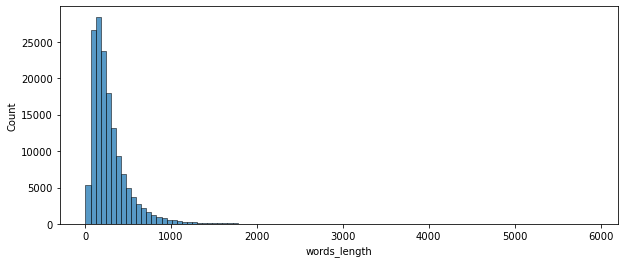

In [12]:
# гистограмма по словам
plt.figure(figsize=(10,4))
sns.histplot(df['words_length'], bins=100)

<AxesSubplot:xlabel='symbols_length', ylabel='Count'>

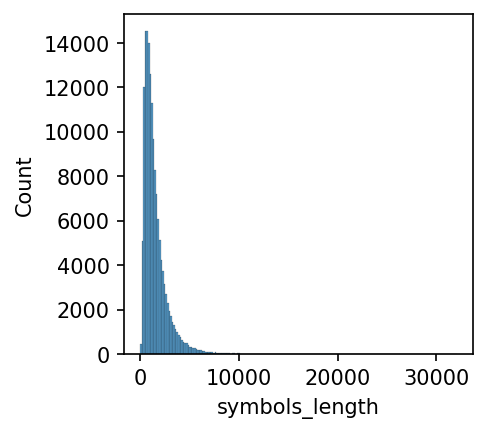

In [13]:
# гистограмма по символам
plt.figure(figsize=(3,3), dpi=150)
sns.histplot(df['symbols_length'], bins=200)

**3. Найдите 10 самых частых:
слов;
слов без стоп-слов;
лемм;
существительных**

In [7]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

10 самых частых слов:

In [8]:
from collections import Counter

In [15]:
corpus = [token for x in df.text for token in nltk.tokenize.word_tokenize(x) if token not in punctuation]
freq_dict = Counter(corpus)

In [16]:
freq_dict = Counter(corpus)

In [17]:
print(f'Самые частые 10 слов: {freq_dict.most_common(10)}')

Самые частые 10 слов: [('в', 1169557), ('и', 980761), ('не', 816419), ('на', 638715), ('что', 603171), ('я', 443478), ('с', 428021), ('по', 338743), ('мне', 293980), ('банка', 235176)]


10 самых частых слов без стоп-слов:

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + list(punctuation) + ['``', "''"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# самое частое слово без стоп слов на выборке 10000:
corpus2 = [token for x in df.text[:10000] for token in nltk.tokenize.word_tokenize(x) if token not in mystopwords]
freq_dict2 = Counter(corpus2)

In [28]:
print(f'Самые частые 10 слов без стоп-слов: {freq_dict2.most_common(10)}')

Самые частые 10 слов без стоп-слов: [('банка', 14606), ('банк', 10023), ('это', 8795), ('В', 8748), ('Я', 7914), ('деньги', 6548), ('карты', 5866), ('карту', 5447), ('...', 4923), ('день', 4630)]


10 самых частых лемм:

In [10]:
!pip install pymorphy2

In [11]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

In [12]:
def lemmatize(text):
    tokens = nltk.tokenize.word_tokenize(text)
    for i, token in enumerate(tokens):
        tokens[i] = pymorphy2_analyzer.parse(token)[0].normal_form
    return tokens

In [24]:
# 10 самых частых лемм на выборке 10000:
corpus3 = [token for x in df.text[:10000] for token in lemmatize(x) if token not in mystopwords]
freq_dict3 = Counter(corpus3)

In [25]:
print(f'Самые частые 10 лемм: {freq_dict3.most_common(10)}')

Самые частые 10 лемм: [('банк', 39257), ('карта', 18714), ('это', 17112), ('``', 11910), ("''", 11842), ('день', 10004), ('всё', 9834), ('кредит', 9710), ('деньга', 9480), ('сотрудник', 9347)]


Комментарии по результатам: в перечень самых частых слов попали в т.ч. символы, которых не было в пунктуации, часть из них убраны и самые частые 10 слов без стоп-слов определены без них, но в леммах не убраны, т.к. время выполнения очень длительное даже на выборке 10000

10 самых частых существительных:

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [73]:
# существительные посчитаем просто по словарю лемм, т.к. самые частые слова там уже указаны. 
# Если нужны не леммы, то можно посчитать по любому другому словарю, который был создан на предыдущих шагах
nouns=[]

for i in sorted(freq_dict3.items(), key=lambda x: x[1], reverse=True):
    if nltk.pos_tag([i[0]])[0][1] == 'NN':
        nouns.append(i[0])
    if len(nouns) >= 10:
        break

print('10 самых частых существительных')
print(*mylist, sep=', ' )

10 самых частых существительных
банк, карта, это, день, всё, кредит, деньга, сотрудник, который, клиент


**4. Постройте кривые Ципфа и Хипса**

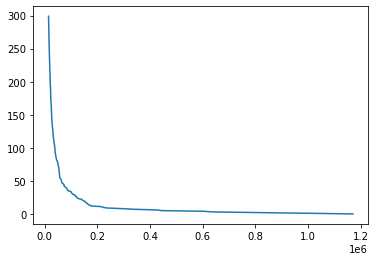

In [76]:
# Кривую Ципфа строим по самому первому словарю со всеми словами
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))

In [14]:
from nltk.tokenize import word_tokenize

In [104]:
# Кривая Хипса без удаления пунктуации


cnt = Counter()
n_words = []
n_tokens = []
tokens = []
x = 0
for index, row in tqdm(df[:10000].iterrows(), total = len(df[:10000])):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    temp = []
    temp = [i for i in cnt.values()] # почему-то некорректно отрабатывал sum(cnt.values()), пришлось делать через список, поэтмоу только на 10000 строках
    n_tokens.append(sum(temp))
        

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:33<00:00, 106.55it/s]


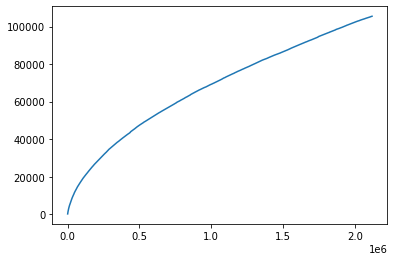

In [105]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

**5. Ответьте на следующие вопросы:**

Какое слово встречается чаще, "сотрудник" или "клиент"?

In [106]:
freq_dict3.most_common(10)

[('банк', 39257),
 ('карта', 18714),
 ('это', 17112),
 ('``', 11910),
 ("''", 11842),
 ('день', 10004),
 ('всё', 9834),
 ('кредит', 9710),
 ('деньга', 9480),
 ('сотрудник', 9347)]

Чаще встречается слово "сотрудник", т.к. оно входит в 10-ку самых частых слов, а клиент - нет, т.е. встречается реже

Сколько раз встречается слова "мошенничество" и "доверие"?

In [111]:
print('мошенничество:', freq_dict3['мошенничество'])
print('доверие', freq_dict3['доверие'])

мошенничество: 219
доверие 151


**6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf-idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)**

Попробуем хотя бы немного предобработать (без лемматизации)

In [ ]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(words_only(text.lower()))

In [ ]:
df.text = df.text.astype('str').apply(preprocess)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
vec = TfidfVectorizer(ngram_range=(2,2))

In [64]:
res1 = vec.fit_transform(df[df['rating_grade']==5]['text'])

In [65]:
# для ключевых слов
vectorizer = TfidfVectorizer(ngram_range=(1,1))

In [66]:
res2 = vectorizer.fit_transform(df[df['rating_grade']==5]['text'])

In [67]:
res3 = vec.fit_transform(df[df['rating_grade']==1]['text'])

In [68]:
res4 = vectorizer.fit_transform(df[df['rating_grade']==1]['text'])

Ключевые слова:

In [69]:
vectorizer.get_feature_names_out()

array(['аа', 'ааа', 'аааа', ..., 'ящук', 'яя', 'яяяяясненько'],
      dtype=object)

Биграммы:

In [70]:
vec.get_feature_names_out()

array(['аа ааа', 'аа балета', 'аа борис', ..., 'ящичку среди',
       'яя обратился', 'яяяяясненько высказал'], dtype=object)

## Тематическое моделирование

In [58]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [71]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

**1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.**

In [72]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [74]:
from gensim.models import lsimodel

In [75]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

In [76]:
lsi.show_topics(5)

[(0,
  '0.120*"карту" + 0.120*"деньги" + 0.117*"карты" + 0.106*"кредит" + 0.102*"заявление" + 0.093*"банк" + 0.091*"банка" + 0.087*"г" + 0.086*"смс" + 0.084*"рублей"'),
 (1,
  '0.313*"кредит" + 0.206*"кредита" + 0.182*"звонки" + -0.174*"карту" + -0.164*"карты" + -0.154*"банкомат" + -0.129*"деньги" + -0.118*"карта" + -0.116*"вклад" + 0.104*"кредиту"'),
 (2,
  '-0.273*"вклад" + -0.191*"вклада" + 0.166*"руб" + 0.157*"банкомат" + 0.146*"заявление" + 0.146*"сбербанка" + 0.126*"рублей" + -0.125*"очереди" + 0.112*"карты" + -0.111*"минут"'),
 (3,
  '0.308*"звонки" + 0.294*"номер" + 0.196*"телефона" + -0.172*"руб" + 0.136*"базы" + 0.133*"данных" + 0.132*"номера" + -0.129*"сумму" + -0.128*"кредита" + 0.127*"поступают"'),
 (4,
  '0.272*"банкомат" + 0.215*"вклад" + -0.202*"карта" + -0.199*"карты" + 0.190*"вклада" + 0.169*"деньги" + -0.154*"карту" + 0.132*"киви" + 0.127*"персональных" + 0.115*"звонки"')]

In [77]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=3)

In [78]:
lsi.show_topics(3)

[(0,
  '0.120*"деньги" + 0.120*"карту" + 0.117*"карты" + 0.106*"кредит" + 0.103*"заявление" + 0.093*"банк" + 0.091*"банка" + 0.088*"г" + 0.086*"смс" + 0.084*"рублей"'),
 (1,
  '0.271*"кредит" + 0.246*"звонки" + -0.183*"вклад" + 0.173*"кредита" + -0.147*"карту" + -0.138*"карты" + 0.131*"номер" + -0.130*"вклада" + -0.118*"банкомат" + -0.111*"деньги"'),
 (2,
  '0.246*"звонки" + 0.185*"номер" + 0.183*"вклад" + -0.177*"руб" + 0.143*"базы" + 0.141*"данных" + -0.141*"банкомат" + 0.140*"телефона" + 0.138*"персональных" + 0.135*"поступают"')]

Тема "0.246*"звонки" + 0.185*"номер" + 0.183*"вклад" + -0.177*"руб" + 0.143*"базы" + 0.141*"данных" + -0.141*"банкомат" + 0.140*"телефона" + 0.138*"персональных" + 0.135*"поступают" понятна и интерпретируема - при использовании услуг банка и предоставления своего телефона (персональных данных) клиентам начинают поступать звонки. Вероятно, клиенты считают, что утечка данных идет из банка, где они открывали вклад или этот банк даже как-то плохо защищает свои базы данных

**2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?**

'-0.273*"вклад" + -0.191*"вклада" + 0.166*"руб" + 0.157*"банкомат" + 0.146*"заявление" + 0.146*"сбербанка" + 0.126*"рублей" + -0.125*"очереди" + 0.112*"карты" + -0.111*"минут"'),

Судя по всему речь идет о сложности открытия вклада в сбербанке, когда приходится подавать заявление физически, в итоге идут жалобы на очереди и перечисление, сколько минут было потрачено на это

## Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
df[df['rating_grade']==5]

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
98,г. Санкт-Петербург,False,"Хорошо, когда проблемы решаются",0,лицензия № 1073,apka45,Русславбанк,2015-06-03 17:40:38,досрочно закрывали вклады отпуском жена заказы...,5.0
122,г. Нижний Новгород,False,Изменяют проценты по уже открытому договору вк...,3,лицензия № 226,20157673,РосинтерБанк,2015-06-04 09:38:18,хотел открыть вклад доходный год проценты начи...,5.0
157,г. Москва,False,"Отделение Марксистская, дом 5: спасибо за помощь!",0,лицензия № 1623,ospar,ВТБ 24,2015-06-04 22:58:38,вчера июня просидев очереди х часов получение ...,5.0
259,г. Москва,False,Хорошее обслуживание,0,лицензия № 3206,ser-gyr,Соверен Банк,2015-06-02 18:23:41,сегодня открывал вклад банке очередь одного кл...,5.0
266,г. Москва,False,Моя история получения кредита в Ренессанс Кред...,1,лицензия № 3354,SkaIa,Ренессанс Кредит,2015-06-03 02:03:28,история получения кредита ренессанс кредит бан...,5.0
...,...,...,...,...,...,...,...,...,...,...
153488,None,False,Повысилось качество обслуживания,0,лицензия № 1623,Атмос,ВТБ 24,2005-04-13 12:00:00,пользуюсь банком месяца специально открыл счет...,5.0
153489,None,False,Стабильный банк с высокими процентами,0,лицензия № 1971,Александра,Ханты-Мансийский банк Открытие,2005-04-14 13:41:00,писать ставки вкладам высокие остатки картам в...,5.0
153491,None,False,Ну тогда копите денюжки и покупайте не в креди...,4,лицензия № 2289,irzik,Русский Стандарт,2005-04-14 17:42:00,мужем обставила техникой совершенно новую квар...,5.0
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,слишком большой банк учитывает нашу специфику ...,5.0


In [82]:
# N2 возьмем 10000
good = df[df['rating_grade']==5][:10000].copy()

In [81]:
df[df['rating_grade']==1]

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,открыт вклад счет плюс этому зарплатная карта ...,1.0
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,доброго времени вчера поступило смс уведомлени...,1.0
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,г около часов пришел указанный офис намерением...,1.0
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,оплаты коммунальных платежей пользуюсь пластик...,1.0
94,г. Чапаевск,False,Некомпетентность сотрудника Сбербанка при пров...,16,лицензия № 1481,usmanovaket,Сбербанк России,2015-06-03 16:00:12,апреле года пришла отделение сбербанка г чапае...,1.0
...,...,...,...,...,...,...,...,...,...,...
153484,None,False,Долг за овердрафт,0,лицензия № 2557,Роман,Ситибанк,2005-04-13 21:06:00,должен овердрафт рублей карту активировал ужас...,1.0
153490,None,False,А судьи кто?,0,лицензия № 2557,Марина,Ситибанк,2005-04-13 22:17:00,ситуация разу воспользовавшись картой имею дол...,1.0
153493,None,False,Два конфликта с банком.,0,лицензия № 2771,Sam,Юниаструм Банк,2005-05-18 01:25:00,оформил банке кредитную карту январе г первый ...,1.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,уважаемое руководство банка овк проживаю г ива...,1.0


In [83]:
# N1 возьмем 40000
bad = df[df['rating_grade']==1][:40000].copy()

In [88]:
total = pd.concat([good, bad])

In [114]:
X_train, X_test, y_train, y_test = train_test_split(total.text, total['rating_grade'], test_size=0.3)

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных 
n-грам.

In [117]:
vectorizer = TfidfVectorizer()

In [119]:
vectorizer.fit(X_train)

TfidfVectorizer()

In [122]:
res_tfidf = vectorizer.transform(X_train.tolist())

In [123]:
baseline = RandomForestClassifier()

In [124]:
baseline.fit(res_tfidf, y_train)

RandomForestClassifier()

In [125]:
X_test_tfidf = vectorizer.transform(X_test.tolist())

In [126]:
y_pred = baseline.predict(X_test_tfidf)

In [127]:
from sklearn.metrics import classification_report

In [128]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.91      1.00      0.95     12034
         5.0       1.00      0.61      0.75      2966

    accuracy                           0.92     15000
   macro avg       0.95      0.80      0.85     15000
weighted avg       0.93      0.92      0.91     15000



**3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков**

In [129]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


In [130]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('tm', TruncatedSVD()), ('clf', RandomForestClassifier())])

In [131]:
y_pred2 = clf.predict(X_test)

In [132]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

         1.0       0.83      0.93      0.88     12034
         5.0       0.46      0.24      0.32      2966

    accuracy                           0.79     15000
   macro avg       0.65      0.59      0.60     15000
weighted avg       0.76      0.79      0.77     15000



Качество, при использовании 1-го варианта (tf-idf преобразования и сингулярного разложения) в итоге ухудшилось, т.к. accuracy и f1-score ниже